# How Good is this Firm?

You have been assigned to the private equity department for the next six months. Private equity department invests in firms that are not public listed. Part of your duty is to analyze target firms and make recommendations as to whether the firms are worth investing.

You have 60 months of data from one firm. Of the 60 months, the firm had good performance in 40 and poor performance in 20. Your supervisor has asked you to analyze if the firm has potential (“good firm”) or not (“bad firm”). You believe that half the firms in the market are good and half are bad. For good firms, they have a 70% chance of achieving good performance in any given month, while for bad firms they only have 50% chance of doing so.

The question is, given the data, how do you figure out the chance that the current firm is a good one?


### Analytical Solution 

First, let us ask a simpler question: how likely is a firm going to do well in 40 months out of 60? That is exactly what the binomial distribution tells us. Let $i$ be the type of firm, $p_i$ the chance of achieving good performance in a given month, $n$ the total number of months and $k$ the number of good months. The binomial distribution says the chance that a firm of type $i$ is going to do well in 40 months out of 60 is:
$$
P\left(X \mid i\right)=\begin{pmatrix} n \\ k \end{pmatrix} p_i^{k} \left(1-p_i \right)^{n-k}
$$
So how likely is a good firm going to do well in 40 months out of 60? Using the formula above:
$$
P\left(X \mid G\right)=\begin{pmatrix} 60 \\ 40 \end{pmatrix} 0.7^{40} 0.3^{20}
$$
We can use the excel function ```BINOM.DIST(40,60,0.7,FALSE)``` to compute the value of this expression, which turns out to be 0.0931.

Similarly, the chance that a bad firm is going to do well in 40 months out of 60 is
$$
P\left(X \mid B\right)=\begin{pmatrix} 60 \\ 40 \end{pmatrix} 0.5^{40} 0.5^{20}=0.0036
$$
With these two numbers, we can find the chance that the firm is a good one with Bayes Rule:
$$
\begin{aligned}
P(G│X) &= \frac{P \left (X \mid G \right)P\left(G\right)}{P\left(X\right)}  \\ 
&=\frac{0.0931\times0.5}{0.0931\times0.5+0.0036\times0.5} \\
&=0.962 
\end{aligned}
$$
So there is 96.2% chance that the firm is good. (Would you have guessed this number without going through the math?)

While we were able to solve this case analytically, this is an exception rather than the norm in reality. In more difficult situation, we will have numerically approximate the chance.


### Markov Chain Monte Carlo (MCMC) Sampling

We randomly draw a firm and keep it with probability:
$$
\min{\left[1, \frac{P\left(X \mid i\right)P\left(i\right)}{P\left(X \mid c\right)P\left(c\right)}\right]}
$$
where $c$ is the type of the last firm we kept. Repeat this process long enough and the distribution of firms we kept will converge to the ratio we found in the analytical solution above.


In [29]:
#Simulation count
sim_count = 50000

#Prior P(i)
p_i = [0.5,0.5]

import random
import numpy as np
from scipy.stats import binom
%matplotlib inline
import matplotlib.pyplot as plt

#P(x|i)P(i)
pxi_pi = [binom.pmf(40,60,0.5)*p_i[0],
        binom.pmf(40,60,0.7)*p_i[1]]

#MCMC
x_list = []
x_current = 1
for i in range(sim_count):
    x_proposal = random.randint(0,1)
    
    if pxi_pi[x_proposal]/pxi_pi[x_current] >= random.random():
        x_current = x_proposal
    
    x_list.append(x_current)

#Print estimate    
print("Estimated P(G|X):",np.sum(x_list)/len(x_list))    

Estimated P(G|X): 0.96128


The downside of MCMC is that it could take a long time to converge. We can see this graphically if we plot the estimates at each time step.  Even for a scenario as simple as ours, it takes more than 15000 steps before the estimate stabilize.

Text(0,0.5,'estimate')

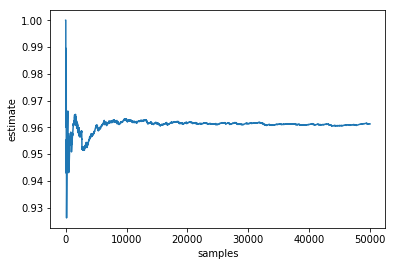

In [30]:
#Plot estimate at each time step
base = np.arange(len(x_list)) + 1
mcmc = np.cumsum(x_list)/base
fig, ax = plt.subplots()
ax.plot(mcmc)    
ax.set_xlabel("samples")
ax.set_ylabel("estimate")

### Why does this Make Sense?

Let $X=\begin{bmatrix} x_G \\ x_B \end{bmatrix}$, where $x_G$ is the chance that a firm is good
and $x_B$ is the chance that the firm is bad. 
This means, for example, 
- $X=\begin{bmatrix} 1 \\ 0 \end{bmatrix}$ represent a firm that is certainly good,
- $X=\begin{bmatrix} 0 \\ 1 \end{bmatrix}$ represent a firm that is certainly bad, and
- $X=\begin{bmatrix} 0.6 \\ 0.4 \end{bmatrix}$ represent a firm that has 60% chance of being good.

We make an initial guess $X_0$ and then draw a second firm based on our initial guess. The distribution of our second firm, $X_1$, is given by
$$
X_1=PX_0
$$
where the transition matrix $P$ corresponds to the chance of keeping a firm given in the previous part. 

After we draw the second firm, we draw a third firm based on our second firm. The distribution of our third firm, $X_2$, is given by 
$$
X_2=PX_1
$$
By now you probably realize what we are trying to do here: the distributions of the firms that we keep $X_1,X_2,X_3,…$ form a Markov Chain, where draws in different time periods are related to each other in the following way:
$$
X_{t+1}=PX_t
$$
As we have learnt in the class on Markov Chains, under certain conditions $X_t$ will converge to a stable vector. 

But what does the stable vector represent? If you look how we record firms in each time step,
acceptance probability is increasing in 
$$
\frac{P\left(X \mid i\right)P\left(i\right)}{P\left(X \mid c\right)P\left(c\right)}
$$
What this means is that for any two given types of firms, we always accept more often the one that is more likely. Furthermore, this difference in acceptance probability is proportional to the relative likelihood of the two types. It is for this reason that that stable vector represents the chances of the firm being good and bad, which is what we are looking for.


### Continuous Type

MCMC can be applied to problem much more complex that the one we have here. As an example, let us modify our code to handle continuous firm type&mdash;type $i\in[0,1]$ has probability $i$ of having good performance in a given month:

Most probable type: 0.6621044263247156


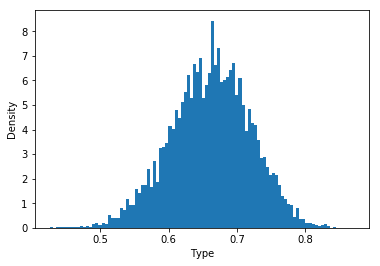

In [25]:
#Simulation count
sim_count = 50000

def pxi_pi(p):
    #P(x|i)P(i)
    return binom.pmf(40,60,p)

def MCMC():
    #MCMC
    x_list = []
    x_current = 0.6
    for i in range(sim_count):
        x_proposal = max(0,min(1,random.gauss(x_current,0.5)))

        if pxi_pi(x_proposal)/(pxi_pi(x_current) + 0.0001) >= random.random():
            x_current = x_proposal

        x_list.append(x_current)
        
    return x_list

#Run MCMC
x_list = MCMC()

#Histogram
n, bins, patches = plt.hist(x_list, 100, density=True)
print("Most probable type:",bins[np.argmax(n)])
plt.xlabel('Type')
plt.ylabel('Density')
plt.show()

A few things to note here:
- The histogram above shows the *posterior distribution* of types. The better a type can explain the data, the higher will its density be. The most probable type is 0.66, which makes sense since 40 good months out of 60 equals 0.67.
- Instead of sampling new firms randomly, we sample firms based on a normal distrbution with the previous accepted type as mean. This very common sampling method is called the <a href="https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm">Metropolis-Hastings algorithm</a>.
- This script is significantly slower than the first one due to the fact that we are calling ```binom.pmf()``` in every single time step. We need to do this because firm type is continuous, so it is impossible to pre-calculate and cache the probability mass function ahead of time. We can bring back pre-calculation and caching if we are willing to sacrifice some precision and discretize firm type:

Most probable type: 0.6721735211908857


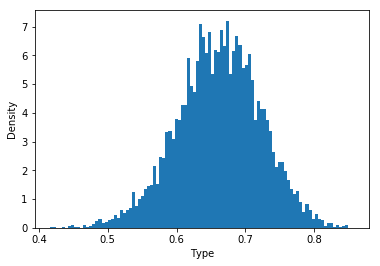

In [12]:
#Simulation count
sim_count = 50000

class pxipi:
    #P(x|i)P(i)
    
    def __init__(self):
        #Calculate and cache binomial distribution at 0.1 interval
        self.pxi_pi = [binom.pmf(40,60,p/100) for p in range(1,101)]
    
    def get(self,p):
        #Return P(x|i)P(i)     
        return self.pxi_pi[round(p*100)-1]

def MCMC():
    #MCMC
    pxi_pi = pxipi()
    x_list = []
    x_current = 0.6
    for i in range(sim_count):
        x_proposal = max(0,min(1,random.gauss(x_current,0.5)))

        if pxi_pi.get(x_proposal)/(pxi_pi.get(x_current) + 0.0001) >= random.random():
            x_current = x_proposal

        x_list.append(x_current)
        
    return x_list

#Run MCMC
x_list = MCMC()

#Histogram
n, bins, patches = plt.hist(x_list, 100, density=True)
print("Most probable type:",bins[np.argmax(n)])
plt.xlabel('Type')
plt.ylabel('Density')
plt.show()

### Further Reading

If you are interested in knowing more about MCMC, I highly recommend Thomas Wiechki's <a href="https://twiecki.github.io/blog/2015/11/10/mcmc-sampling/">MCMC sampling for dummies</a>.